#### TESTING EXPERIMENTAL SAMPLE NUMBER

This script generates an exponential (or weibull) probability density function described by its parameters $\lambda$ (or $shape$ and $scale$). 

We study the accuracy of a cdf extracted by an number $N$ of samples by means of the Kolmogorov-Smirnoff distance metric (https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)


A.M Moreno-Rodenas, Den Haag, 12-07-23

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, weibull_min, ks_2samp
from tqdm import tqdm
import pandas as pd

%matplotlib widget

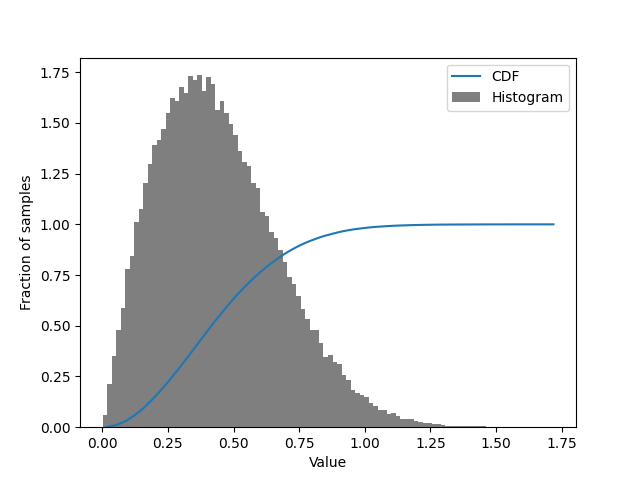

In [2]:
# 1- Initiate an exponential pdf distribution

distribution = 'weibull'

if distribution == 'exponential':
    lambda_ = 0.5  # rate parameter for the exponential distribution
    rv = expon(scale=1/lambda_)
elif distribution == 'weibull':
    # 1- Initiate a Weibull pdf distribution
    shape = 2.0  # shape parameter for the Weibull distribution
    scale = 0.5  # scale parameter for the Weibull distribution
    rv = weibull_min(c=shape, scale=scale)
else:
    print('Select a distribution')

# 2- Create N=100000 samples and show its histogram
N_large = 100000
samples_large = rv.rvs(size=N_large)

# Compute values for CDF
counts, bin_edges = np.histogram(samples_large, bins=100, density=True)
cdf = np.cumsum(counts) / np.sum(counts)

plt.figure()
# Plotting
plt.plot(bin_edges[1:], cdf, label='CDF')
plt.xlabel('Value')
plt.ylabel('Fraction of samples')
plt.hist(samples_large, bins=100, density=True, alpha=0.5, color = 'k', label='Histogram')
plt.legend()
plt.show()

In [3]:
# 3- Create a subsample of N=100
N_small = 50
samples_small = np.random.choice(samples_large, N_small)

# compute the kolmogorov smirnoff distance between the cdfs of both samples
D, p_value = ks_2samp(samples_large, samples_small)

print(f"Kolmogorov-Smirnov distance: {D}")
print(f"P-value: {p_value}")

Kolmogorov-Smirnov distance: 0.09321000000000002
P-value: 0.742669417697184


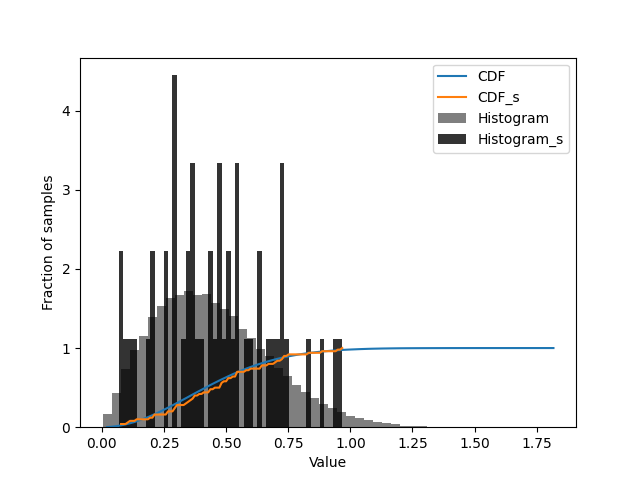

In [4]:
# now plot the sample

# Compute values for CDF
counts_s, bin_edges_s = np.histogram(samples_small, bins=100, density=True)
cdf_s = np.cumsum(counts_s) / np.sum(counts_s)

plt.figure()
# Plotting
plt.plot(bin_edges[1:], cdf, label='CDF')
plt.plot(bin_edges_s[1:], cdf_s, label='CDF_s')

plt.xlabel('Value')
plt.ylabel('Fraction of samples')
plt.hist(samples_large, bins=50, density=True, alpha=0.5, color = 'k', label='Histogram')
plt.hist(samples_small, bins=50, density=True, alpha=0.8, color = 'k', label='Histogram_s')

plt.legend()
plt.show()

In [5]:
# 4- Now we test the effect of the sample size on the KS index. We do this by creating multiple replicates of length ranging from 10-300 samples.
ks_distances = []
num_samples_list = []
p_values = []

# Loop over the range of sample sizes
for num_samples in tqdm(range(10, 300, 10)):

    # For each sample size, generate 100 random subsamples and compute the ks distance
    for _ in range(100):
        samples_small = np.random.choice(samples_large, num_samples)
        D, p_value = ks_2samp(samples_large, samples_small)

        # Add the ks distance and sample size to our lists
        ks_distances.append(D)
        num_samples_list.append(num_samples)
        p_values.append(p_value)

100%|██████████| 29/29 [00:28<00:00,  1.02it/s]


In [6]:
# Convert lists to a pandas DataFrame
data = pd.DataFrame({
    'Number of Samples': num_samples_list,
    'KS Distance': ks_distances,
    'p_values' : p_values
})

# Compute the mean KS distance for each number of samples
mean_ks_distances = data.groupby('Number of Samples')['KS Distance'].mean()
mean_p_values = data.groupby('Number of Samples')['p_values'].mean()

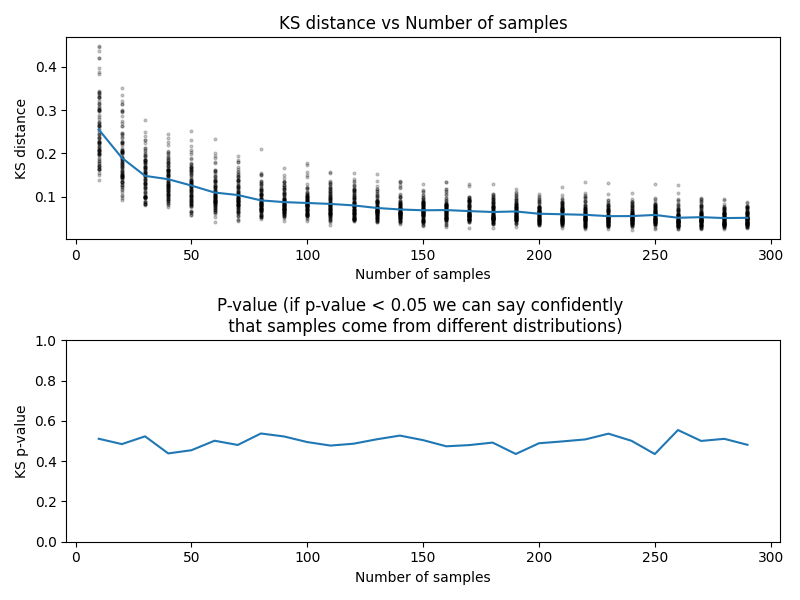

In [7]:
# Plot the KS distances versus the number of samples

fig, ax = plt.subplots(2,figsize = (8,6))

ax1 = ax[0]
ax1.scatter(num_samples_list, ks_distances, c = 'k', s = 4, alpha=0.2)
ax1.plot(mean_ks_distances)
ax1.set_xlabel('Number of samples')
ax1.set_ylabel('KS distance')
ax1.set_title('KS distance vs Number of samples')

ax2 = ax[1]
ax2.plot(mean_p_values)
ax2.set_xlabel('Number of samples')
ax2.set_ylabel('KS p-value')
ax2.set_title('P-value (if p-value < 0.05 we can say confidently \n that samples come from different distributions)')
ax2.set_ylim(0,1)

plt.tight_layout()

##### Computing the cdf from real samples

In [9]:
## I will create some synthetic data (times_exp):

# Let's assume 'times' are the transport times for the 90 elements
times = np.random.exponential(scale=0.5, size=90)  # replace with your actual data
times = np.concatenate([times, np.ones(10)*np.nan])
np.random.shuffle(times) # This represents 100 observations for which 10% of the samples did not get transported
times_exp = pd.DataFrame(times, columns=['time_transport'])


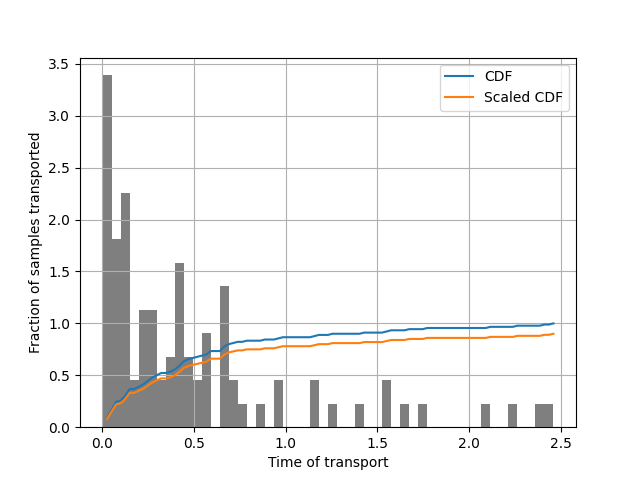

In [10]:
times_transport = times_exp['time_transport'].dropna()
n_nontrasported = np.sum(np.isnan(times_exp['time_transport']))  ## number of samples that are nan
n_samples = len(times_exp['time_transport'])

# Compute values for CDF
counts, bin_edges = np.histogram(times_transport, bins=100, density=True)

cdf = np.cumsum(counts) / np.sum(counts)
cdf_s = np.cumsum(counts) / np.sum(counts) * (1 - n_nontrasported/n_samples)  # scale the CDF with the % of elements that have transported -- (n_samples - n_nontransported)/n_samples

plt.figure()
# Plotting

plt.plot(bin_edges[1:], cdf, label='CDF')
plt.plot(bin_edges[1:], cdf_s, label='Scaled CDF')
plt.hist(times_transport, bins = 50, color = 'k', alpha = 0.5, density = True)
plt.xlabel('Time of transport')
plt.ylabel('Fraction of samples transported')
# plt.ylim([0, 1])  # Ensure y-axis goes from 0 to 1 for clarity
plt.legend()
plt.grid(True)
plt.show()